# Rectificacion y medicion de imagenes

En este ejercicio vamos a rectificar una imagen usando las medidas conocidas de un carnet para medir
la distancia entre dos monedas.



Cargamos las imagenes y funciones necesarias.


In [5]:
import numpy as np
import cv2   as cv
import imutils          # Multiples funciones utiles
import matplotlib.pyplot as plt
import numpy.linalg      as la



from ipywidgets          import interactive

from scipy               import ndimage # Filling holes
%matplotlib inline

def fig(w,h):
    plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread(file), cv.COLOR_BGR2RGB) 

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)

def imshowg(x):
    plt.imshow(x, "gray")

#para imprimir arrays con el número de decimales deseados
import contextlib

@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield
    np.set_printoptions(**original)

# imprime un array con pocos decimales
def sharr(a, prec=3):
    with printoptions(precision=prec, suppress=True):
        print(a)

# dibuja un polígono cuyos nodos son las filas de un array 2D
def shcont(c, color='blue', nodes=True):
    x = c[:,0]
    y = c[:,1]
    x = np.append(x,x[0])
    y = np.append(y,y[0])
    plt.plot(x,y,color)
    if nodes: plt.plot(x,y,'.',color=color, markerSize=11)


# crea un vector (array 1D)
# (no es imprescindible, numpy admite tuplas o listas en muchas funciones,
# pero a esta función es útil a veces para aplicar operaciones aritméticas)
def vec(*argn):
    return np.array(argn)

# convierte un conjunto de puntos ordinarios (almacenados como filas de la matriz de entrada)
# en coordenas homogéneas (añadimos una columna de 1)
def homog(x):
    ax = np.array(x)
    uc = np.ones(ax.shape[:-1]+(1,))
    return np.append(ax,uc,axis=-1)

# convierte en coordenadas tradicionales
def inhomog(x):
    ax = np.array(x)
    return ax[..., :-1] / ax[...,[-1]]

# estas dos funciones funcionan en espacios de cualquier dimensión.

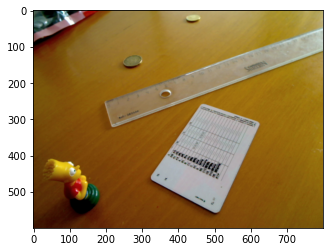

In [6]:
coins = readrgb("../img/REC/coins.png")
plt.imshow(coins)

Usaremos el carnet para calcular las distancias entre las monedas, vamos a umbralizar el carnet para selecionar 4 puntos los cuales
luego los extenderemos encontrando asi las verdaderas esquinas del carnet.

In [7]:
# Pasamos a monocroma
coins_mono = rgb2gray(coins.copy())
# Aplicamos un filtro gausiano para reducir imperfeciones.
img = cv.GaussianBlur(coins_mono, (5, 5), 0)
def aply_threshold(mini= 150 ,maxi=255):
    ret, gt = cv.threshold(img,mini,maxi,cv.THRESH_BINARY)
    print(ret)
    imshowg(gt);

interactive(aply_threshold, mini=(0,255,1), maxi=(0,255,1))


interactive(children=(IntSlider(value=150, description='mini', max=255), IntSlider(value=255, description='max…

Buscamos los bordes con la funcion auto_canny de imutils y los dilatamos para que se unan.

In [8]:
def find_contours(mini= 150 ,maxi=255,dilation=1):
    ret, gt = cv.threshold(img,mini,maxi,cv.THRESH_BINARY)
    edges = imutils.auto_canny(gt)
    # Taking a matrix of size 5 as the kernel 
    kernel = np.ones((3,3), np.uint8) 
    img_dilation = cv.dilate(edges, kernel, iterations=dilation) 
    imshowg(img_dilation)

interactive(find_contours, mini=(0,255,1), maxi=(0,255,1),dilation=(1,10,1))


interactive(children=(IntSlider(value=150, description='mini', max=255), IntSlider(value=255, description='max…

Podemos ir modificando el threshold para encontrar un rectangulo con mayor area pero la diferencia no es muy significativa

In [9]:
def find_true_color(mini=150,maxi=255,draw=True):
    original = coins.copy()
    # Pasamos a monocroma
    coins_mono = rgb2gray(coins.copy())
    # Aplicamos un filtro gausiano para reducir imperfeciones.
    img = cv.GaussianBlur(coins_mono, (3, 3), 0)
    # Aplicamos el filtro threshold
    ret, gt = cv.threshold(img,mini,maxi,cv.THRESH_BINARY)
    edges = imutils.auto_canny(gt)
    #Dilatanamos
    kernel = np.ones((3,3), np.uint8)
    img_dilation = cv.dilate(edges, kernel, iterations=1)
    #Buscamos contornos
    contours, _hierarchy = cv.findContours(img_dilation, cv.RETR_EXTERNAL , cv.CHAIN_APPROX_SIMPLE)
    squares  = []
    for cnt in contours:
        # Reducimos el numero de vertices
        cnt_len = cv.arcLength(cnt, True)
        # Douglas-Peucker algorithm
        cnt = cv.approxPolyDP(cnt, 0.1*cnt_len, True)
        if len(cnt) == 4 and cv.contourArea(cnt) > 1000:
            if draw:
                print(f"Contorno area {cv.contourArea(cnt)}")
            squares.append(cnt)
    if draw:
        print(f"Hay {len(squares)}")
        cv.drawContours(original, squares, -1, (0, 255, 0), 3 )
        cv.drawContours(edges, squares, -1, (255, 255, 255), 3 )
        fig(18,6)
        plt.subplot(1,2,1)
        plt.imshow(original); plt.title('Color')
        plt.subplot(1,2,2)
        plt.imshow(edges,"gray"); plt.title('points');
    return squares

interactive(find_true_color, mini=(0,255,1), maxi=(0,255,1))



interactive(children=(IntSlider(value=150, description='mini', max=255), IntSlider(value=255, description='max…

Otra manera de obtener los bordes podria haber sido buscando un tramo recto y extendiendolo hasta el infinito pero
no encuentro niguna manera de medio atomatizarlo.Con esto me refiero que si, puedo selecionar varios puntos a mano y extenderlos pero no se como automatizar esto.

Una vez tengamos las 4 esquinas encontradas hay que aplica una transformacion para rectificar el carnet
Para esto creamos un rectangulo que este mas menos cerca de donde se recticaria el carnet

El factor de escala que he elegido es 3 pixel por milímetro y el carnet mide (85mm$\times$54mm)


In [10]:
original = find_true_color(draw=False)
print(f"Puntos originales {original[0]}")

Puntos originales [[[465 257]]

 [[324 462]]

 [[510 556]]

 [[625 311]]]


Ya tengo los 4 puntos de mi carnet en la imagen orignal (sin rectificar) ahora lo que tenemos que crear un rectangulo con
las dimensiones que tendria el carnet si un pixel fueran 3 milimetros.

In [12]:
aumento = 3
alto = 54 * aumento
ancho = 85 * aumento
real_safe = np.array([
    [465., 257.],
    [465., 257 + ancho],
    [465+alto, 257 + ancho],
    [465+alto, 257.],
])
real = real_safe.copy()
original = np.array([
    [465., 257.],
    [324., 462.],
    [510., 556.],
    [625., 311.],
])

fig(4,5); shcont(original);shcont(real); plt.axis([0,800,600,0]);

[[   1.669    2.08  -519.447]
 [  -0.645    2.699   43.62 ]
 [   0.       0.002    1.   ]]


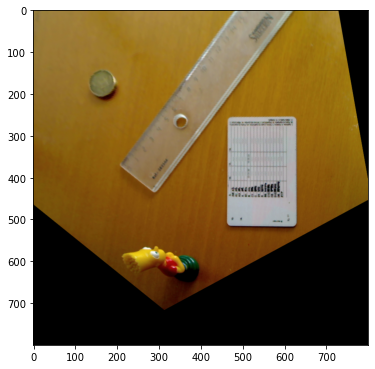

In [13]:
rec = cv.warpPerspective(coins.copy(),H,(800,800))

fig(6,8)
plt.imshow(rec); 

Como se puede ver la imagen sale muy arriba para evitarlo creamos una serie de funciones para mover el rectangulo


In [14]:
# aplica una transformación homogénea h a un conjunto
# de puntos ordinarios, almacenados como filas
def htrans(h,x):
    return inhomog(homog(x) @ h.T)
def desp(d):
    dx,dy = d
    return np.array([
            [1,0,dx],
            [0,1,dy],
            [0,0,1]])

def scale(s):
    sx,sy = s
    return np.array([
            [sx,0,0],
            [0,sy,0],
            [0,0,1]])

# rotación eje "vertical" del plano
def rot3(a):
    c = np.cos(a)
    s = np.sin(a)
    return np.array([
            [c,-s,0],
            [s, c,0],
            [0, 0,1]])

pi = np.pi
degree = pi/180

In [15]:
def mueve_carnet(x = 150,y =285,draw=True):
    H = desp((x,y))
    real= real_safe.copy()
    real_trans = htrans(H,real)
    H,_ = cv.findHomography(original, real_trans)
    rec = cv.warpPerspective(coins.copy(),H,(1000,1000))
    if draw:
        fig(8,8)
        plt.imshow(rec);
    else:
        return rec
    

interactive(mueve_carnet, x=(-465,500,1),y=(-257,500,1))

interactive(children=(IntSlider(value=150, description='x', max=500, min=-465), IntSlider(value=285, descripti…

Una vez que tenemos la imagen transformada podemos medir el numero de pixeles entre las monedas y calcular su distancia
Como selecionar puntos con matplot es algo difil use el script `mouse.py`
- Moneda 1 316 429
- Moneda 2 368 154

La longitud en pixel es 279.8731855680354 y en mm es 93.29106185601181 mn


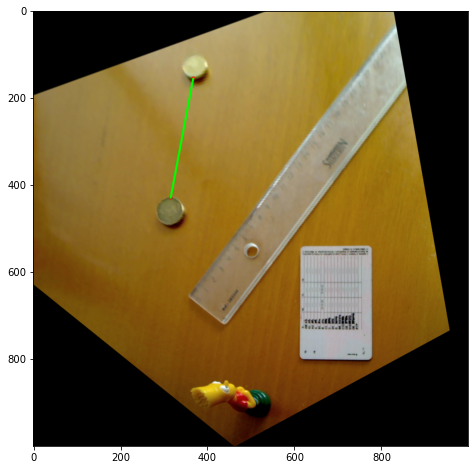

In [16]:
import math
img = mueve_carnet(draw=False)
p1= (316,429)
p2 = (368,154)
cv.circle(img, p1, 4,(255,0,0), -1)
cv.circle(img, p2, 4,(255,0,0), -1)
cv.line(img, p1, p2, (0, 255, 0), thickness=3)
longitud = math.hypot(368 - 316, 154 - 429)
fig(8,8)
plt.imshow(img);
print(f"La longitud en pixel es {longitud} y en mm es {longitud/aumento} mn")
